## Questions1:

In [ ]:
import numpy as np
from numpy import deg2rad
import skimage.io
import skimage.color
from skimage.util.noise import random_noise
from skimage.transform import resize as img_resize
from skimage.transform import rotate as img_rotate
from matplotlib import pyplot
import matplotlib.pyplot as plt
import math
import copy
import os
from scipy.spatial.distance import cdist
from scipy.sparse.linalg import eigsh
from scipy.linalg import eigh

import cv2
import numpy as np
from sklearn.cluster import KMeans

# 1.First_segment(Gray_Image)

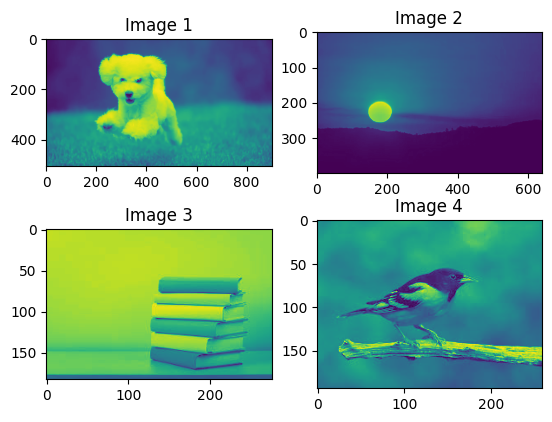

In [ ]:
images=['img1.jpeg','img2.jpeg','img3.jpeg','img4.jpeg']
for i in range(4):
  img=skimage.io.imread(images[i])
  images[i]=skimage.color.rgb2gray(img)
fig, axes = plt.subplots(2, 2)
axes[0, 0].imshow(images[0])
axes[0, 1].imshow(images[1])
axes[1, 0].imshow(images[2])
axes[1, 1].imshow(images[3])

axes[0, 0].set_title("Image 1")
axes[0, 1].set_title("Image 2")
axes[1, 0].set_title("Image 3")
axes[1, 1].set_title("Image 4")
plt.show()

In [ ]:
def compute_w_elements(img_gray,x_i=(0,0),x_j=(0,0),vec_sigma=500,f_i=None,f_j=None,fet_sigma=0.03,r=50):
    if(f_i==None):
        f_i=img_gray[x_i[0]][x_i[1]]
    if(f_j==None):
        f_j=img_gray[x_j[0]][x_j[1]]
    x_snorm=((x_i[0]-x_j[0])**2)+((x_i[1]-x_j[1])**2)
    if(x_snorm>=(r**2)):
        return 0.0
    else:
        f_snorm=(f_i-f_j)**2
        temp1=math.exp((-1*f_snorm)/(fet_sigma**2))
        temp2=math.exp((-1*x_snorm)/(vec_sigma**2))
        return temp1*temp2

In [ ]:
def node_num(loc,img_gray):
    return (loc[0]*img_gray.shape[1])+loc[1]

def node_loc(nodenum, img_gray):
    col=nodenum%img_gray.shape[1]
    row=(nodenum-col)//(img_gray.shape[1])
    return (row,col)


In [ ]:
def compute_w_matrix(img_gray):
    total_len=img_gray.shape[0]*img_gray.shape[1]
    w_matrix=np.array([[0.0 for i in range(img_gray.shape[0]*img_gray.shape[1])] for j in range(img_gray.shape[0]*img_gray.shape[1])])
    for i1 in range(img_gray.shape[0]):
        for j1 in range(img_gray.shape[1]):
            node_number1=node_num((i1,j1),img_gray)
            for i2 in range(img_gray.shape[0]):
                for j2 in range(img_gray.shape[1]):
                    node_number2=node_num((i2,j2),img_gray)
                    similarity=0.0
                    similarity=compute_w_elements(img_gray,x_i=(i1,j1),x_j=(i2,j2))
                    w_matrix[node_number1][node_number2]=similarity
    return w_matrix

In [ ]:
def compute_d_matrix(w_matrix):
    d_matrix=np.zeros(w_matrix.shape,dtype="float")
    total_len=w_matrix.shape[0]
    for i in range(w_matrix.shape[0]):
        temp=0
        for j in range(w_matrix.shape[1]):
            temp+=w_matrix[i][j]
        d_matrix[i][i]=temp
    return d_matrix


In [ ]:
def compute_n_cut(img_gray,d_matrix,w_matrix):
    d_matrix_sqrt=np.zeros(d_matrix.shape,dtype="float")
    for i in range(d_matrix.shape[0]):
        d_matrix_sqrt[i][i]=math.sqrt(d_matrix[i][i])
    d_matrix_sqrt_inv=np.linalg.inv(d_matrix_sqrt)
    diff_matrix=d_matrix-w_matrix
    main_matrix=np.matmul(np.matmul(d_matrix_sqrt_inv,(diff_matrix)),d_matrix_sqrt_inv)
    gen_eigen_vals , gen_eigen_vects = np.linalg.eig(main_matrix)
    del main_matrix
    del d_matrix_sqrt_inv
    del d_matrix_sqrt
    del w_matrix
    del d_matrix

    min_eigen_val=min(gen_eigen_vals)
    sec_min_eig_val=np.inf
    sec_min_eig_index=0
    for i in range(gen_eigen_vals.shape[0]):
        el=gen_eigen_vals[i]
        if(el<sec_min_eig_val and el>min_eigen_val):
            sec_min_eig_val=el
            sec_min_eig_index=i
    sec_min_eig_vect=np.transpose(gen_eigen_vects)[sec_min_eig_index]
    del gen_eigen_vals
    del gen_eigen_vects
    threshold=np.median(sec_min_eig_vect)
    for i in range(sec_min_eig_vect.shape[0]):
        if(sec_min_eig_vect[i]>=threshold):
            sec_min_eig_vect[i]=1
        else:
            sec_min_eig_vect[i]=0
    part_img=np.zeros(img_gray.shape,dtype="float")
    for node in range(sec_min_eig_vect.shape[0]):
        loc=node_loc(node,img_gray)
        if(sec_min_eig_vect[node]>0.5):
            part_img[loc[0]][loc[1]]=1.0
    pyplot.imshow(part_img)
    pyplot.show()
    return part_img

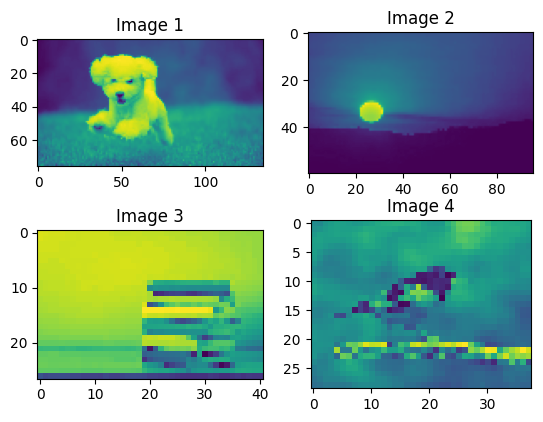

In [ ]:
for i in range(4):
  width,height=images[i].shape
  new_width,new_height=int(width*0.15),int(height*0.15)
  images[i]=cv2.resize(images[i],(new_height,new_width))
fig, axes = plt.subplots(2, 2)
axes[0, 0].imshow(images[0])
axes[0, 1].imshow(images[1])
axes[1, 0].imshow(images[2])
axes[1, 1].imshow(images[3])

axes[0, 0].set_title("Image 1")
axes[0, 1].set_title("Image 2")
axes[1, 0].set_title("Image 3")
axes[1, 1].set_title("Image 4")
plt.show()

In [ ]:
w_matrix=[0]*4
d_matrix=[0]*4
for i in range(4):
  w_matrix[i]=compute_w_matrix(images[i])
  d_matrix[i]=compute_d_matrix(w_matrix[i])
  print(f"Image{i+1}_degree_matrix: ", d_matrix[i],"\n")


Image1_degree_matrix:  [[116.71219679   0.           0.         ...   0.           0.
    0.        ]
 [  0.         138.33250379   0.         ...   0.           0.
    0.        ]
 [  0.           0.         189.67726259 ...   0.           0.
    0.        ]
 ...
 [  0.           0.           0.         ...  86.08783869   0.
    0.        ]
 [  0.           0.           0.         ...   0.          66.41779937
    0.        ]
 [  0.           0.           0.         ...   0.           0.
   56.21261544]] 

Image2_degree_matrix:  [[161.44923611   0.           0.         ...   0.           0.
    0.        ]
 [  0.         190.41330097   0.         ...   0.           0.
    0.        ]
 [  0.           0.         204.96200264 ...   0.           0.
    0.        ]
 ...
 [  0.           0.           0.         ... 975.70785996   0.
    0.        ]
 [  0.           0.           0.         ...   0.         961.76057035
    0.        ]
 [  0.           0.           0.         ...   0.       

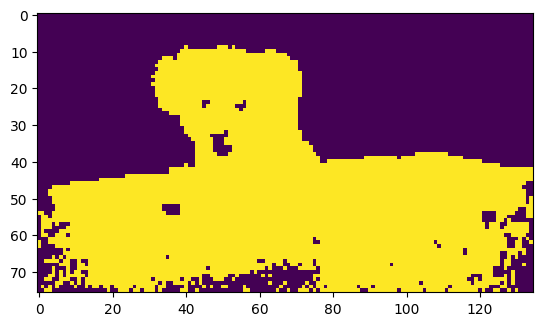

In [ ]:
segmented=[0]*4
segmented[0]=compute_n_cut(images[0],d_matrix[0],w_matrix[0])


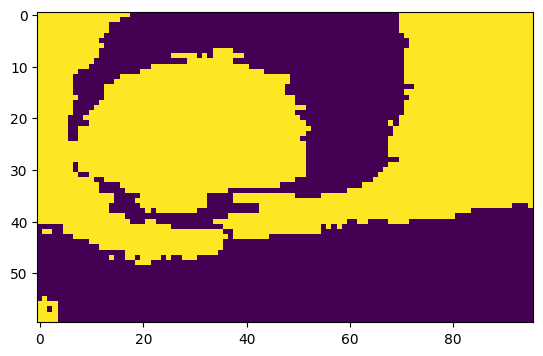

In [ ]:
segmented[1]=compute_n_cut(images[1],d_matrix[1],w_matrix[1])


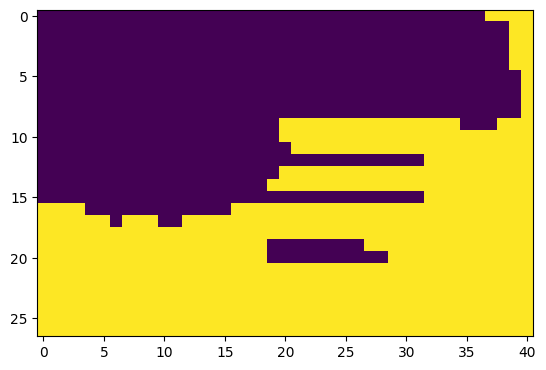

In [ ]:
segmented[2]=compute_n_cut(images[2],d_matrix[2],w_matrix[2])

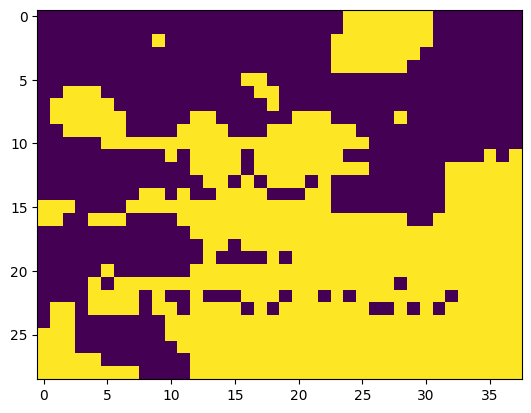

In [ ]:
segmented[3]=compute_n_cut(images[3],d_matrix[3],w_matrix[3])

# 2.Two_segments(RGB_image)

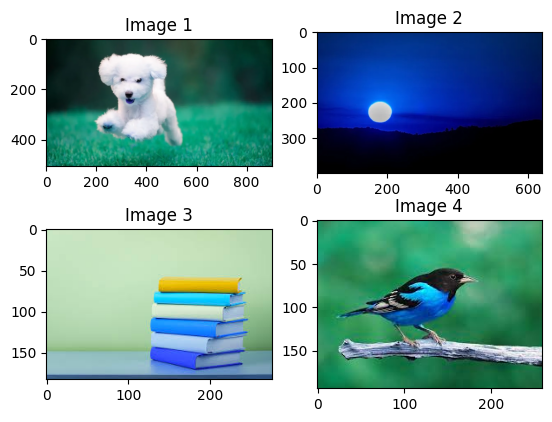

In [ ]:
images2=['img1.jpeg','img2.jpeg','img3.jpeg','img4.jpeg']
for i in range(4):
  images2[i]=cv2.imread(images2[i])
fig, axes = plt.subplots(2, 2)
axes[0, 0].imshow(images2[0])
axes[0, 1].imshow(images2[1])
axes[1, 0].imshow(images2[2])
axes[1, 1].imshow(images2[3])

axes[0, 0].set_title("Image 1")
axes[0, 1].set_title("Image 2")
axes[1, 0].set_title("Image 3")
axes[1, 1].set_title("Image 4")
plt.show()

In [ ]:
for i in range(4):
  width,height,depth=images2[i].shape
  new_width,new_height=int(width*0.1),int(height*0.1)
  images2[i]=cv2.resize(images2[i],(new_height,new_width))

In [ ]:
def compute_w_matrix2(img,sigma_I):
    if len(img.shape) == 3 and img.shape[2] == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    pixels = np.reshape(img, (img.shape[0] * img.shape[1], img.shape[2]))
    euclidean_distance_matrix = cdist(pixels, pixels, metric='euclidean')
    similarity_matrix = np.exp(-euclidean_distance_matrix * 2 / (2. * sigma_I * 2))
    return similarity_matrix

In [ ]:
w_matrix2=[0]*4
d_matrix2=[0]*4
sigma=[ 4.245,1.939,4.19,3.93053]
for i in range(4):
  w_matrix2[i]=compute_w_matrix2(images2[i],sigma[i])
  d_matrix2[i]=compute_d_matrix(w_matrix2[i])
  print(f"Image{i+1}_degree_matrix: ", d_matrix2[i],"\n")


Image1_degree_matrix:  [[55.69118126  0.          0.         ...  0.          0.
   0.        ]
 [ 0.         60.63894975  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         85.37779113 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... 62.64834608  0.
   0.        ]
 [ 0.          0.          0.         ...  0.         72.57304573
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  68.17102961]] 

Image2_degree_matrix:  [[ 30.61373201   0.           0.         ...   0.           0.
    0.        ]
 [  0.          32.80916255   0.         ...   0.           0.
    0.        ]
 [  0.           0.          32.63176427 ...   0.           0.
    0.        ]
 ...
 [  0.           0.           0.         ... 422.24113931   0.
    0.        ]
 [  0.           0.           0.         ...   0.         422.24113931
    0.        ]
 [  0.           0.           0.         ...   0.           0.
  422.24113931]] 

Image3_deg

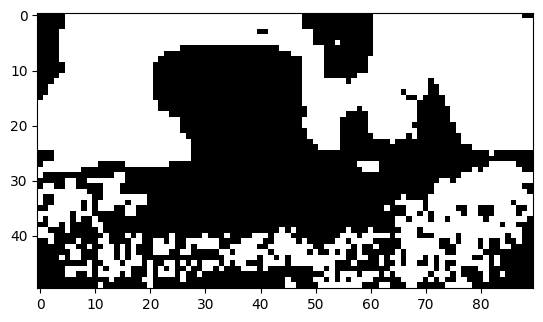

In [ ]:
compute_n_cut(images2[0],d_matrix2[0],w_matrix2[0])

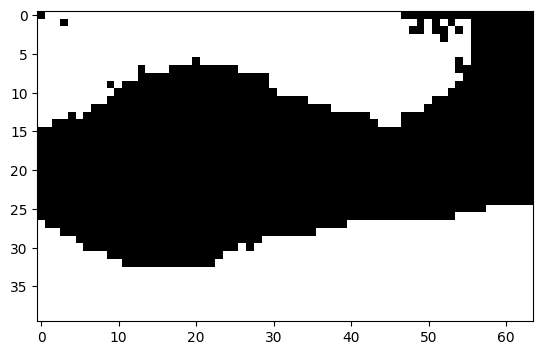

In [ ]:
compute_n_cut(images2[1],d_matrix2[1],w_matrix2[1])

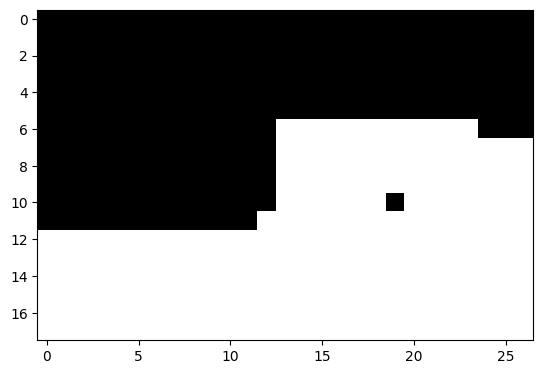

In [ ]:
compute_n_cut(images2[2],d_matrix2[2],w_matrix2[2])

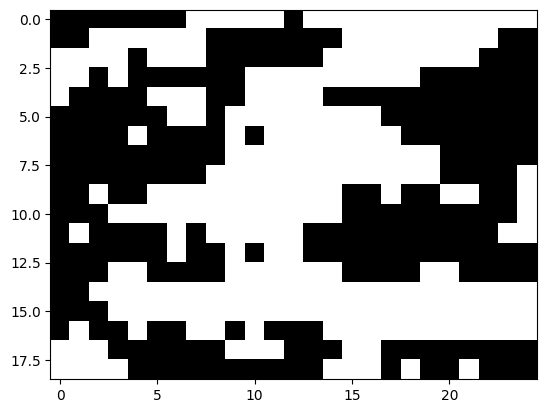

In [ ]:
compute_n_cut(images2[3],d_matrix2[3],w_matrix2[3])

# 3. Three_segments

In [ ]:
images[0].shape,segmented[0].shape

((76, 135), (76, 135))

In [ ]:
def find_vector(flat_image,sigma_I):
    W=similarity_matrix_vect(flat_image,sigma_I)
    D=compute_d_matrix(W)
    A=D-W
    D_inverse=np.linalg.inv(D)
    mat=np.matmul(D_inverse,A)
    num_eigenvectors = 2
    eigenvalues, eigenvectors = eigsh(mat, k=num_eigenvectors, which='SM')
    sec_vector=eigenvectors.T[1].reshape(-1,1)
    median=np.median(sec_vector)
    for i in range(sec_vector.shape[0]):
      if sec_vector[i]<median:
        sec_vector[i]=150
      else:
        sec_vector[i]=255
    return sec_vector

def similarity_matrix_vect(flat_image,sigma_I):
  size=flat_image.shape[0]
  matrix=np.zeros((size,size))
  for i in range(size):
    for j in range(i,size):
      int_diff=abs(int(flat_image[i])-int(flat_image[j]))
      val1=math.e**(-((int_diff**2)/(sigma_I**2)))
      matrix[i][j]=val1
      matrix[j][i]=matrix[i][j]
  return matrix


In [ ]:
def three_segment(segmented_image,image):
  mask = segmented_image != 0
  segment = np.where(mask, image, 0)
  segment=segment.flatten()
  vect=[]
  for i in range(segment.shape[0]):
    if(segment[i]!=0):
     vect.append(segment[i])
  vect=np.array(vect)
  new_vect=find_vector(vect,0.005)
  k=0
  for i in range(segmented_image.shape[0]):
    for j in range(segmented_image.shape[1]):
     if(segmented_image[i][j]!=0):
       segmented_image[i][j]=new_vect[k]
       k=k+1
  return segmented_image

<ipython-input-6-2c3c3520f660>:48: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  segmented_image[i][j]=new_vect[k]


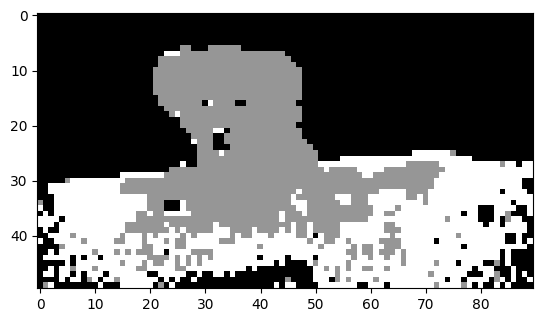

In [ ]:
im1=three_segment(segmented[0],images[0])
plt.imshow(im1,cmap='gray')

# 4.Segments_Using_K-Means

---



/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


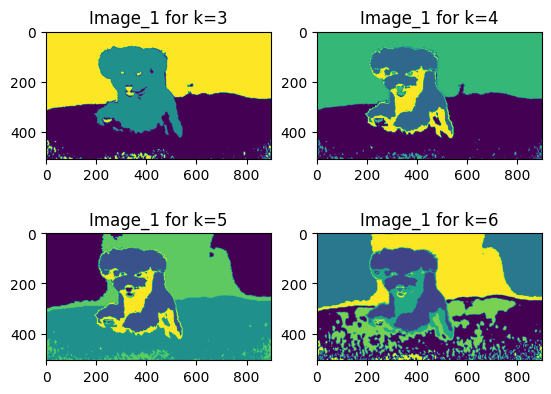

In [ ]:
img=skimage.io.imread('img1.jpeg')
flattened_image = img.reshape((-1, 3))
k_values = range(3, 7)
segmented_image=[0]*4
for k in k_values:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(flattened_image)
    segmented_image[k-3] = kmeans.labels_.reshape(img.shape[:2])

fig, axes = plt.subplots(2, 2)
axes[0, 0].imshow(segmented_image[0])
axes[0, 1].imshow(segmented_image[1])
axes[1, 0].imshow(segmented_image[2])
axes[1, 1].imshow(segmented_image[3])

axes[0, 0].set_title("Image_1 for k=3")
axes[0, 1].set_title("Image_1 for k=4")
axes[1, 0].set_title("Image_1 for k=5")
axes[1, 1].set_title("Image_1 for k=6")
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


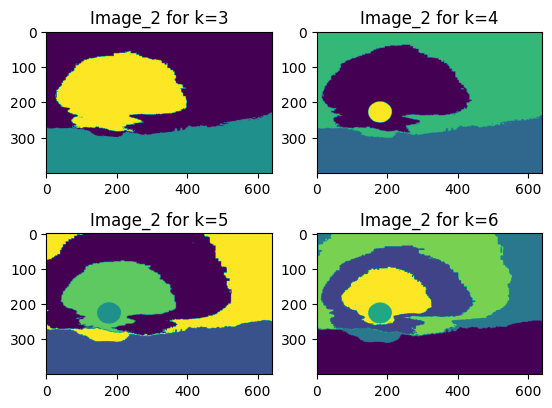

In [ ]:
img=skimage.io.imread('img2.jpeg')
flattened_image = img.reshape((-1, 3))
k_values = range(3, 7)
segmented_image=[0]*4
for k in k_values:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(flattened_image)
    segmented_image[k-3] = kmeans.labels_.reshape(img.shape[:2])

fig, axes = plt.subplots(2, 2)
axes[0, 0].imshow(segmented_image[0])
axes[0, 1].imshow(segmented_image[1])
axes[1, 0].imshow(segmented_image[2])
axes[1, 1].imshow(segmented_image[3])

axes[0, 0].set_title("Image_2 for k=3")
axes[0, 1].set_title("Image_2 for k=4")
axes[1, 0].set_title("Image_2 for k=5")
axes[1, 1].set_title("Image_2 for k=6")
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


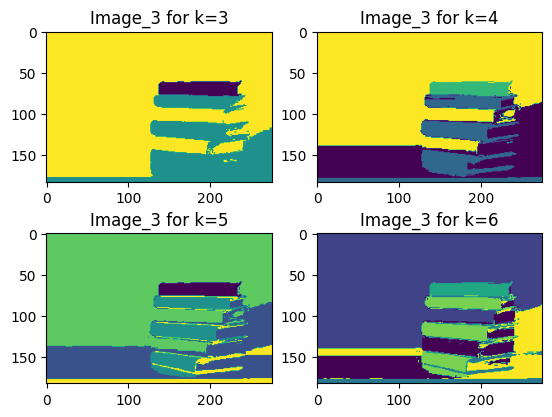

In [ ]:
img=skimage.io.imread('img3.jpeg')
flattened_image = img.reshape((-1, 3))
k_values = range(3, 7)
segmented_image=[0]*4
for k in k_values:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(flattened_image)
    segmented_image[k-3] = kmeans.labels_.reshape(img.shape[:2])

fig, axes = plt.subplots(2, 2)
axes[0, 0].imshow(segmented_image[0])
axes[0, 1].imshow(segmented_image[1])
axes[1, 0].imshow(segmented_image[2])
axes[1, 1].imshow(segmented_image[3])

axes[0, 0].set_title("Image_3 for k=3")
axes[0, 1].set_title("Image_3 for k=4")
axes[1, 0].set_title("Image_3 for k=5")
axes[1, 1].set_title("Image_3 for k=6")
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


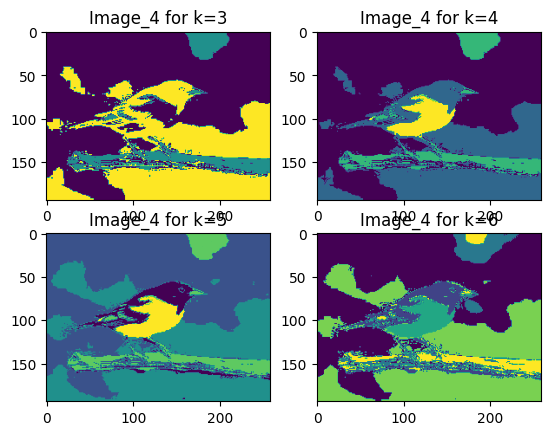

In [ ]:
img=skimage.io.imread('img4.jpeg')
flattened_image = img.reshape((-1, 3))
k_values = range(3, 7)
segmented_image=[0]*4
for k in k_values:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(flattened_image)
    segmented_image[k-3] = kmeans.labels_.reshape(img.shape[:2])

fig, axes = plt.subplots(2, 2)
axes[0, 0].imshow(segmented_image[0])
axes[0, 1].imshow(segmented_image[1])
axes[1, 0].imshow(segmented_image[2])
axes[1, 1].imshow(segmented_image[3])

axes[0, 0].set_title("Image_4 for k=3")
axes[0, 1].set_title("Image_4 for k=4")
axes[1, 0].set_title("Image_4 for k=5")
axes[1, 1].set_title("Image_4 for k=6")
plt.show()